In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
# Load pre-trained ResNet-18 model
import torchvision.models as models

model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Function to create a random patch
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)
    return patch

# Function to apply the patch to images
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

# Training function for adversarial patch
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

# Function to train the adversarial patch
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, trainloader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

# Function to evaluate the success rate of the adversarial patch
def evaluate_patch_success_rate(model, patch, dataloader, target_class=None):
    model.eval()
    successful_attacks = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images.clone(), patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            # Count successful targeted attacks (where prediction matches the target class)
            if target_class is not None:
                successful_attacks += (predicted == target_class).sum().item()
            total_samples += labels.size(0)

    success_rate = 100 * successful_attacks / total_samples
    print(f"Targeted Attack Success Rate: {success_rate:.2f}%")
    return success_rate

# Function to visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

# Function to visualize misclassified patched images
def visualize_misclassified_patched_images(model, patch, dataloader, classes, target_class, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            if patched_preds[i] == target_class:  # Targeted attack
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]



Training for patch size: (3, 3) with target class: plane
Epoch 1/20, Loss: 2.9386
Epoch 2/20, Loss: 2.9387
Epoch 3/20, Loss: 2.9368
Epoch 4/20, Loss: 2.9359
Epoch 5/20, Loss: 2.9333
Epoch 6/20, Loss: 2.9285
Epoch 7/20, Loss: 2.9294
Epoch 8/20, Loss: 2.9245
Epoch 9/20, Loss: 2.9228
Epoch 10/20, Loss: 2.9236
Epoch 11/20, Loss: 2.9247
Epoch 12/20, Loss: 2.9239
Epoch 13/20, Loss: 2.9228
Epoch 14/20, Loss: 2.9228
Epoch 15/20, Loss: 2.9202
Epoch 16/20, Loss: 2.9205
Epoch 17/20, Loss: 2.9235
Epoch 18/20, Loss: 2.9188
Epoch 19/20, Loss: 2.9191
Epoch 20/20, Loss: 2.9202
Visualizing patch of size (3, 3) for target class plane


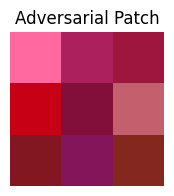

Targeted Attack Success Rate: 3.28%


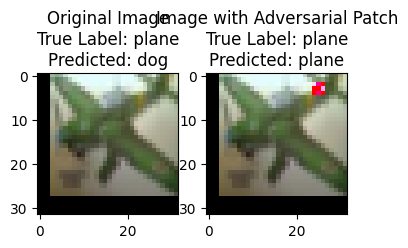

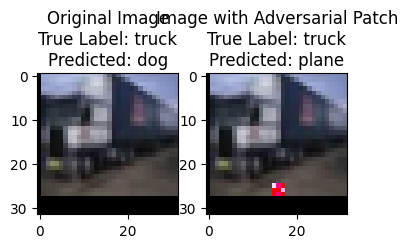

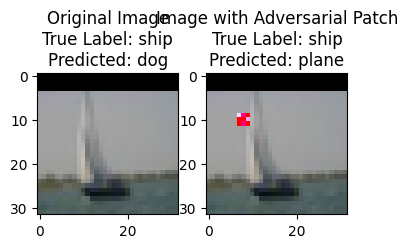

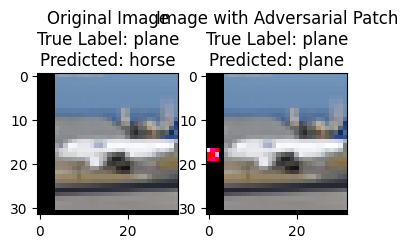

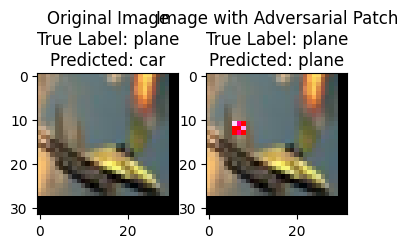


Training for patch size: (5, 5) with target class: plane
Epoch 1/20, Loss: 2.9364
Epoch 2/20, Loss: 2.9289
Epoch 3/20, Loss: 2.9272
Epoch 4/20, Loss: 2.9228
Epoch 5/20, Loss: 2.9221
Epoch 6/20, Loss: 2.9243
Epoch 7/20, Loss: 2.9197
Epoch 8/20, Loss: 2.9200
Epoch 9/20, Loss: 2.9168
Epoch 10/20, Loss: 2.9176
Epoch 11/20, Loss: 2.9183
Epoch 12/20, Loss: 2.9157
Epoch 13/20, Loss: 2.9171
Epoch 14/20, Loss: 2.9143
Epoch 15/20, Loss: 2.9122
Epoch 16/20, Loss: 2.9130
Epoch 17/20, Loss: 2.9110
Epoch 18/20, Loss: 2.9113
Epoch 19/20, Loss: 2.9132
Epoch 20/20, Loss: 2.9084
Visualizing patch of size (5, 5) for target class plane


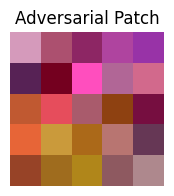

Targeted Attack Success Rate: 3.35%


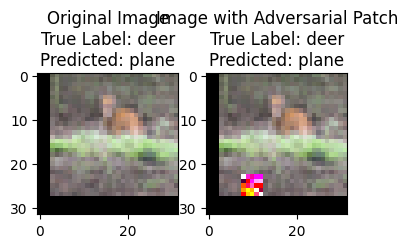

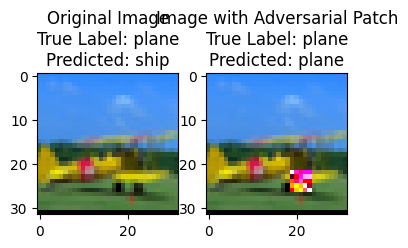

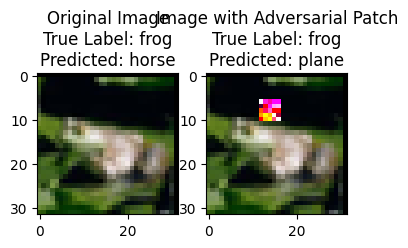

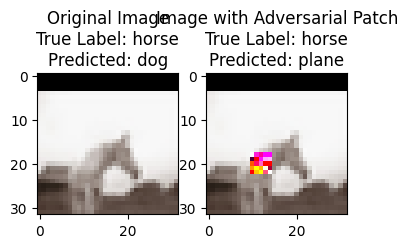

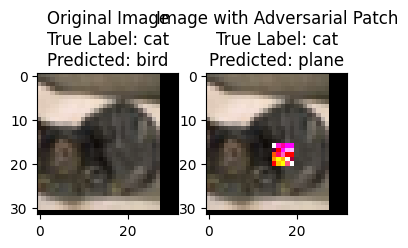


Training for patch size: (7, 7) with target class: plane
Epoch 1/20, Loss: 2.9313
Epoch 2/20, Loss: 2.9270
Epoch 3/20, Loss: 2.9281
Epoch 4/20, Loss: 2.9216
Epoch 5/20, Loss: 2.9178
Epoch 6/20, Loss: 2.9174
Epoch 7/20, Loss: 2.9159
Epoch 8/20, Loss: 2.9178
Epoch 9/20, Loss: 2.9145
Epoch 10/20, Loss: 2.9133
Epoch 11/20, Loss: 2.9129
Epoch 12/20, Loss: 2.9107
Epoch 13/20, Loss: 2.9130
Epoch 14/20, Loss: 2.9115
Epoch 15/20, Loss: 2.9133
Epoch 16/20, Loss: 2.9114
Epoch 17/20, Loss: 2.9107
Epoch 18/20, Loss: 2.9102
Epoch 19/20, Loss: 2.9098
Epoch 20/20, Loss: 2.9064
Visualizing patch of size (7, 7) for target class plane


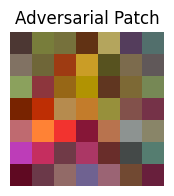

Targeted Attack Success Rate: 3.40%


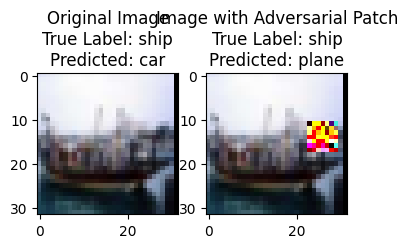

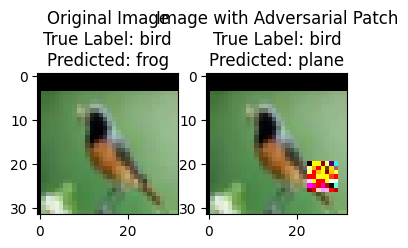

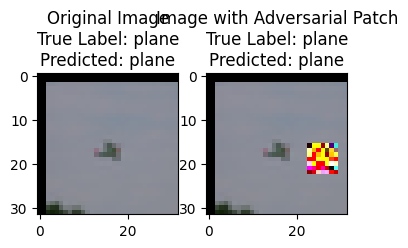

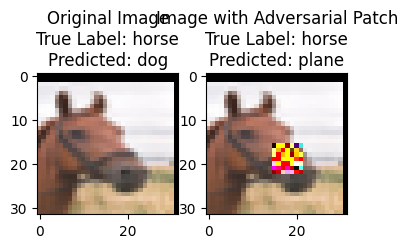

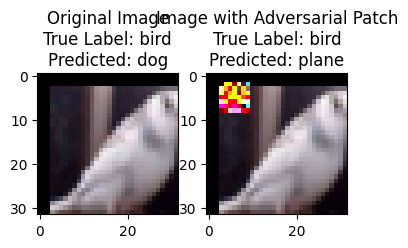


Training for patch size: (16, 16) with target class: plane
Epoch 1/20, Loss: 2.9226
Epoch 2/20, Loss: 2.9117
Epoch 3/20, Loss: 2.9062
Epoch 4/20, Loss: 2.8975
Epoch 5/20, Loss: 2.8916
Epoch 6/20, Loss: 2.8839
Epoch 7/20, Loss: 2.8752
Epoch 8/20, Loss: 2.8676
Epoch 9/20, Loss: 2.8674
Epoch 10/20, Loss: 2.8594
Epoch 11/20, Loss: 2.8516
Epoch 12/20, Loss: 2.8454
Epoch 13/20, Loss: 2.8446
Epoch 14/20, Loss: 2.8389
Epoch 15/20, Loss: 2.8348
Epoch 16/20, Loss: 2.8301
Epoch 17/20, Loss: 2.8292
Epoch 18/20, Loss: 2.8236
Epoch 19/20, Loss: 2.8170
Epoch 20/20, Loss: 2.8182
Visualizing patch of size (16, 16) for target class plane


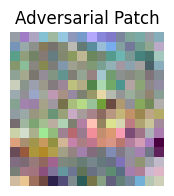

Targeted Attack Success Rate: 3.65%


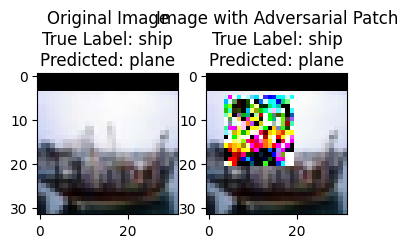

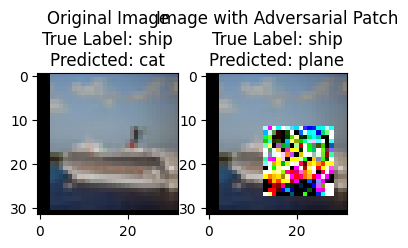

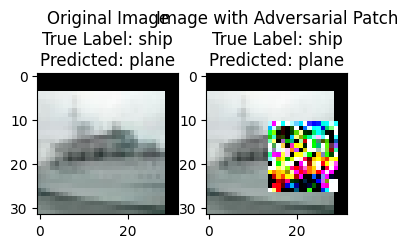

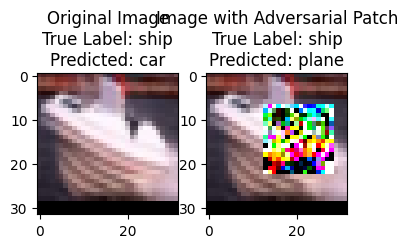

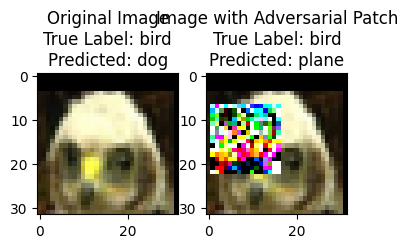


Training for patch size: (3, 3) with target class: car
Epoch 1/20, Loss: 2.1609
Epoch 2/20, Loss: 2.1571
Epoch 3/20, Loss: 2.1573
Epoch 4/20, Loss: 2.1582
Epoch 5/20, Loss: 2.1564
Epoch 6/20, Loss: 2.1579
Epoch 7/20, Loss: 2.1599
Epoch 8/20, Loss: 2.1566
Epoch 9/20, Loss: 2.1581
Epoch 10/20, Loss: 2.1579
Epoch 11/20, Loss: 2.1561
Epoch 12/20, Loss: 2.1579
Epoch 13/20, Loss: 2.1551
Epoch 14/20, Loss: 2.1570
Epoch 15/20, Loss: 2.1563
Epoch 16/20, Loss: 2.1550
Epoch 17/20, Loss: 2.1538
Epoch 18/20, Loss: 2.1539
Epoch 19/20, Loss: 2.1541
Epoch 20/20, Loss: 2.1541
Visualizing patch of size (3, 3) for target class car


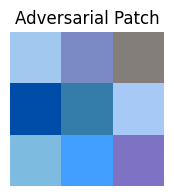

Targeted Attack Success Rate: 16.50%


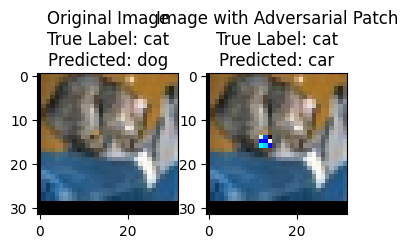

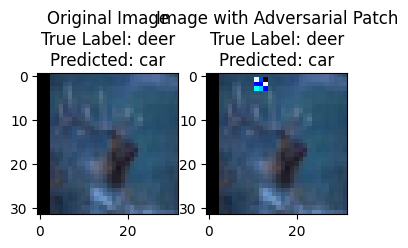

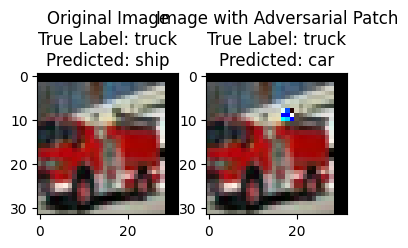

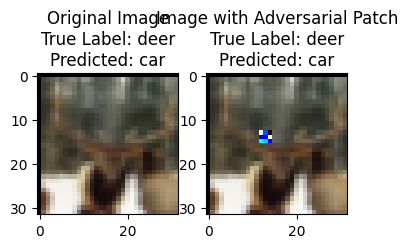

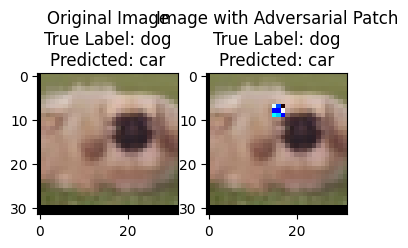


Training for patch size: (5, 5) with target class: car
Epoch 1/20, Loss: 2.1585
Epoch 2/20, Loss: 2.1567
Epoch 3/20, Loss: 2.1564
Epoch 4/20, Loss: 2.1568
Epoch 5/20, Loss: 2.1555
Epoch 6/20, Loss: 2.1544
Epoch 7/20, Loss: 2.1513
Epoch 8/20, Loss: 2.1533
Epoch 9/20, Loss: 2.1521
Epoch 10/20, Loss: 2.1517
Epoch 11/20, Loss: 2.1523
Epoch 12/20, Loss: 2.1527
Epoch 13/20, Loss: 2.1532
Epoch 14/20, Loss: 2.1514
Epoch 15/20, Loss: 2.1521
Epoch 16/20, Loss: 2.1514
Epoch 17/20, Loss: 2.1515
Epoch 18/20, Loss: 2.1506
Epoch 19/20, Loss: 2.1497
Epoch 20/20, Loss: 2.1505
Visualizing patch of size (5, 5) for target class car


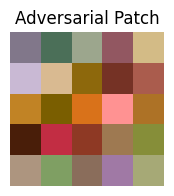

Targeted Attack Success Rate: 17.40%


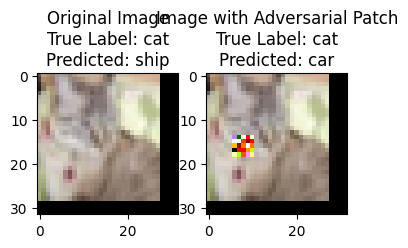

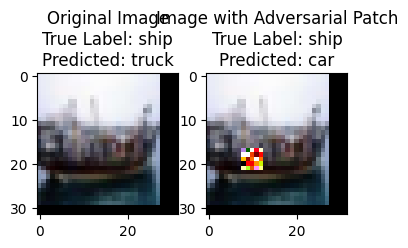

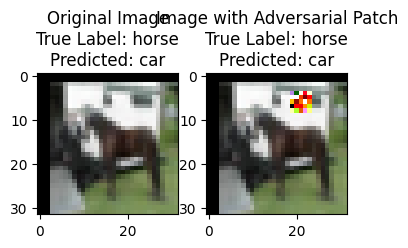

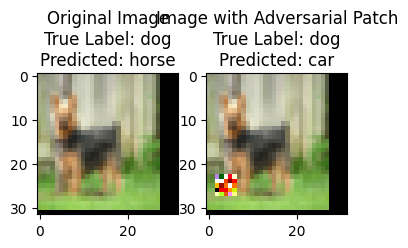

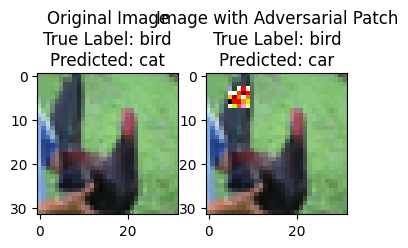


Training for patch size: (7, 7) with target class: car
Epoch 1/20, Loss: 2.1573
Epoch 2/20, Loss: 2.1577
Epoch 3/20, Loss: 2.1550
Epoch 4/20, Loss: 2.1545
Epoch 5/20, Loss: 2.1552
Epoch 6/20, Loss: 2.1519
Epoch 7/20, Loss: 2.1507
Epoch 8/20, Loss: 2.1498
Epoch 9/20, Loss: 2.1521
Epoch 10/20, Loss: 2.1485
Epoch 11/20, Loss: 2.1481
Epoch 12/20, Loss: 2.1478
Epoch 13/20, Loss: 2.1460
Epoch 14/20, Loss: 2.1479
Epoch 15/20, Loss: 2.1480
Epoch 16/20, Loss: 2.1457
Epoch 17/20, Loss: 2.1446
Epoch 18/20, Loss: 2.1470
Epoch 19/20, Loss: 2.1452
Epoch 20/20, Loss: 2.1459
Visualizing patch of size (7, 7) for target class car


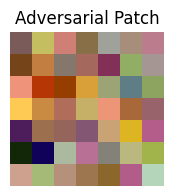

Targeted Attack Success Rate: 17.71%


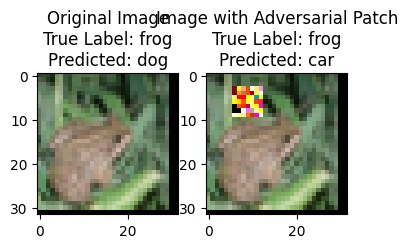

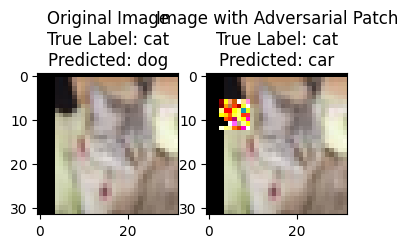

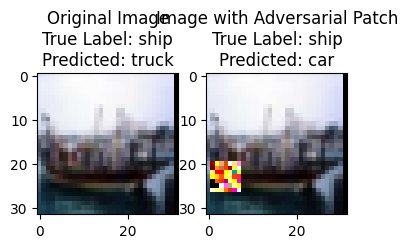

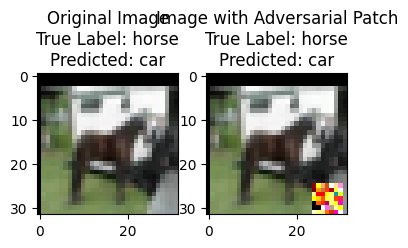

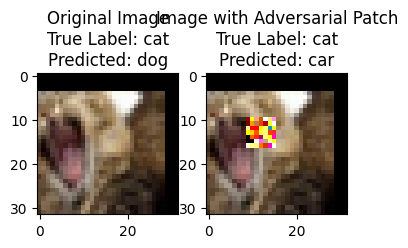


Training for patch size: (16, 16) with target class: car
Epoch 1/20, Loss: 2.1496
Epoch 2/20, Loss: 2.1454
Epoch 3/20, Loss: 2.1391
Epoch 4/20, Loss: 2.1391
Epoch 5/20, Loss: 2.1344
Epoch 6/20, Loss: 2.1345
Epoch 7/20, Loss: 2.1317
Epoch 8/20, Loss: 2.1312
Epoch 9/20, Loss: 2.1268
Epoch 10/20, Loss: 2.1259
Epoch 11/20, Loss: 2.1246
Epoch 12/20, Loss: 2.1244
Epoch 13/20, Loss: 2.1242
Epoch 14/20, Loss: 2.1233
Epoch 15/20, Loss: 2.1225
Epoch 16/20, Loss: 2.1230
Epoch 17/20, Loss: 2.1209
Epoch 18/20, Loss: 2.1222
Epoch 19/20, Loss: 2.1199
Epoch 20/20, Loss: 2.1186
Visualizing patch of size (16, 16) for target class car


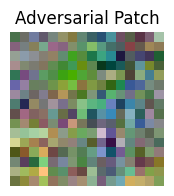

Targeted Attack Success Rate: 18.76%


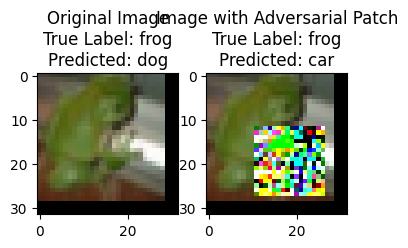

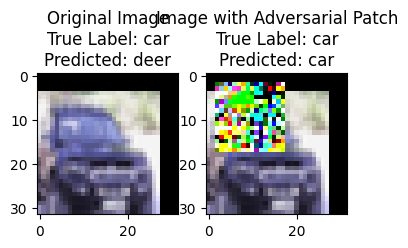

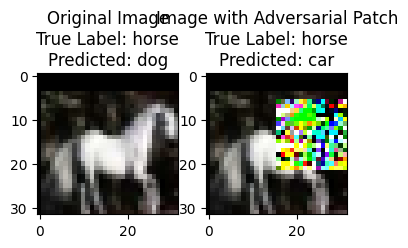

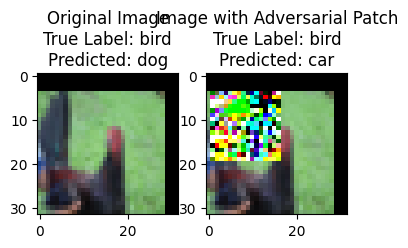

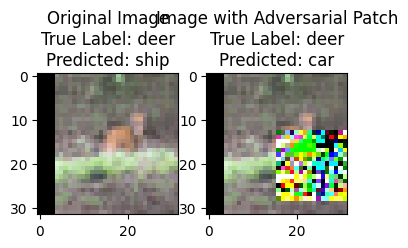


Training for patch size: (3, 3) with target class: bird
Epoch 1/20, Loss: 2.8003
Epoch 2/20, Loss: 2.7970
Epoch 3/20, Loss: 2.7978
Epoch 4/20, Loss: 2.7961
Epoch 5/20, Loss: 2.7961
Epoch 6/20, Loss: 2.7946
Epoch 7/20, Loss: 2.7916
Epoch 8/20, Loss: 2.7952
Epoch 9/20, Loss: 2.7936
Epoch 10/20, Loss: 2.7907
Epoch 11/20, Loss: 2.7932
Epoch 12/20, Loss: 2.7900
Epoch 13/20, Loss: 2.7890
Epoch 14/20, Loss: 2.7882
Epoch 15/20, Loss: 2.7875
Epoch 16/20, Loss: 2.7889
Epoch 17/20, Loss: 2.7868
Epoch 18/20, Loss: 2.7872
Epoch 19/20, Loss: 2.7876
Epoch 20/20, Loss: 2.7877
Visualizing patch of size (3, 3) for target class bird


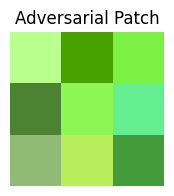

Targeted Attack Success Rate: 2.29%


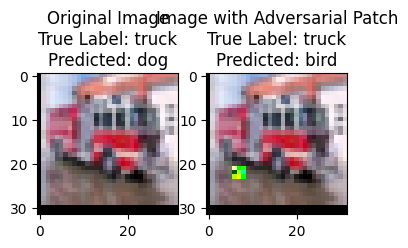

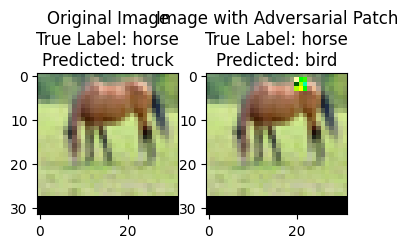

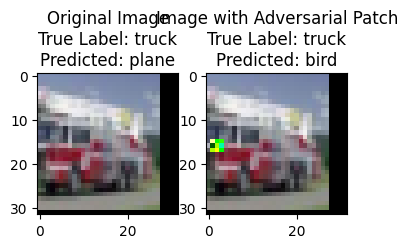

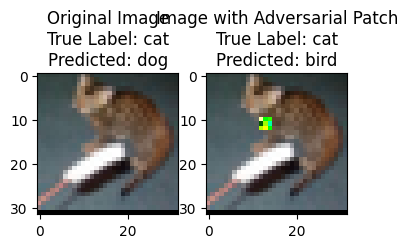

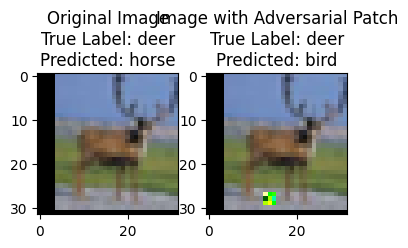


Training for patch size: (5, 5) with target class: bird
Epoch 1/20, Loss: 2.7963
Epoch 2/20, Loss: 2.7941
Epoch 3/20, Loss: 2.7940
Epoch 4/20, Loss: 2.7905
Epoch 5/20, Loss: 2.7895
Epoch 6/20, Loss: 2.7906
Epoch 7/20, Loss: 2.7896
Epoch 8/20, Loss: 2.7855
Epoch 9/20, Loss: 2.7875
Epoch 10/20, Loss: 2.7845
Epoch 11/20, Loss: 2.7835
Epoch 12/20, Loss: 2.7818
Epoch 13/20, Loss: 2.7832
Epoch 14/20, Loss: 2.7819
Epoch 15/20, Loss: 2.7825
Epoch 16/20, Loss: 2.7812
Epoch 17/20, Loss: 2.7797
Epoch 18/20, Loss: 2.7803
Epoch 19/20, Loss: 2.7800
Epoch 20/20, Loss: 2.7790
Visualizing patch of size (5, 5) for target class bird


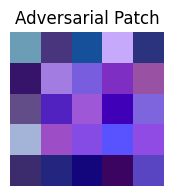

Targeted Attack Success Rate: 2.20%


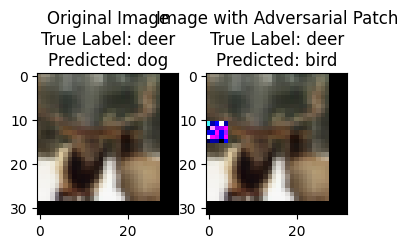

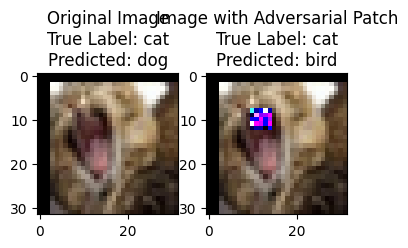

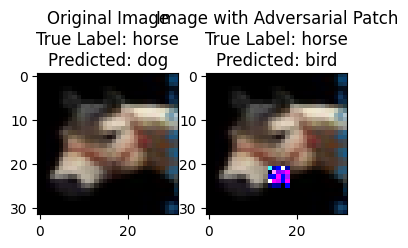

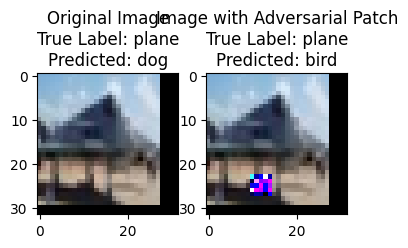

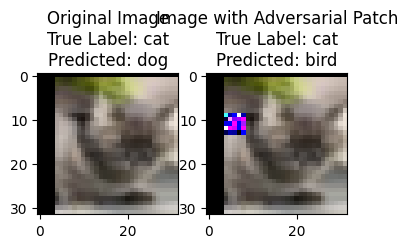


Training for patch size: (7, 7) with target class: bird
Epoch 1/20, Loss: 2.7949
Epoch 2/20, Loss: 2.7957
Epoch 3/20, Loss: 2.7899
Epoch 4/20, Loss: 2.7908
Epoch 5/20, Loss: 2.7900
Epoch 6/20, Loss: 2.7883
Epoch 7/20, Loss: 2.7856
Epoch 8/20, Loss: 2.7867
Epoch 9/20, Loss: 2.7853
Epoch 10/20, Loss: 2.7841
Epoch 11/20, Loss: 2.7850
Epoch 12/20, Loss: 2.7816
Epoch 13/20, Loss: 2.7817
Epoch 14/20, Loss: 2.7825
Epoch 15/20, Loss: 2.7793
Epoch 16/20, Loss: 2.7784
Epoch 17/20, Loss: 2.7800
Epoch 18/20, Loss: 2.7807
Epoch 19/20, Loss: 2.7753
Epoch 20/20, Loss: 2.7764
Visualizing patch of size (7, 7) for target class bird


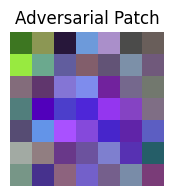

Targeted Attack Success Rate: 1.97%


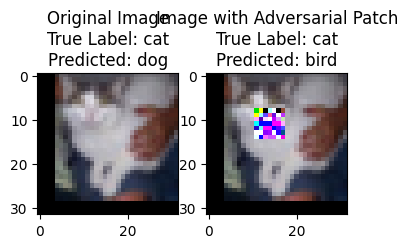

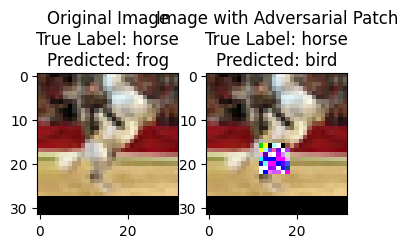

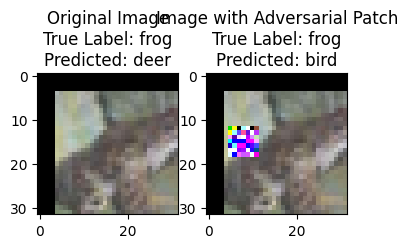

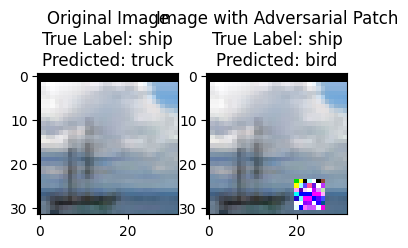

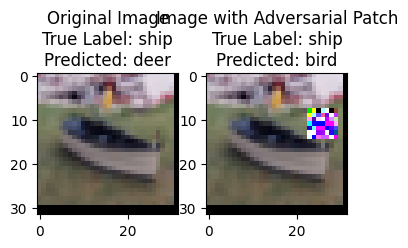


Training for patch size: (16, 16) with target class: bird
Epoch 1/20, Loss: 2.7846
Epoch 2/20, Loss: 2.7752
Epoch 3/20, Loss: 2.7666
Epoch 4/20, Loss: 2.7628
Epoch 5/20, Loss: 2.7605
Epoch 6/20, Loss: 2.7575
Epoch 7/20, Loss: 2.7498
Epoch 8/20, Loss: 2.7449
Epoch 9/20, Loss: 2.7397
Epoch 10/20, Loss: 2.7334
Epoch 11/20, Loss: 2.7288
Epoch 12/20, Loss: 2.7242
Epoch 13/20, Loss: 2.7179
Epoch 14/20, Loss: 2.7132
Epoch 15/20, Loss: 2.7051
Epoch 16/20, Loss: 2.6995
Epoch 17/20, Loss: 2.6948
Epoch 18/20, Loss: 2.6877
Epoch 19/20, Loss: 2.6878
Epoch 20/20, Loss: 2.6788
Visualizing patch of size (16, 16) for target class bird


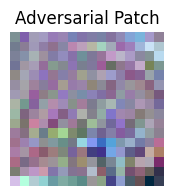

Targeted Attack Success Rate: 2.59%


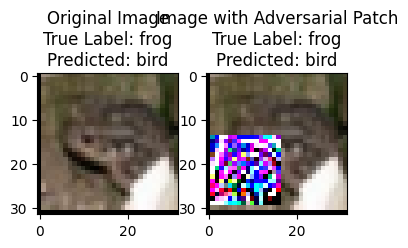

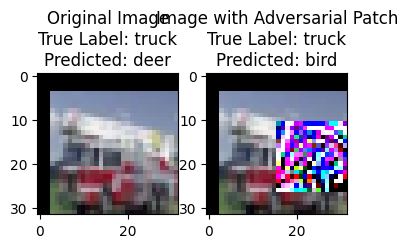

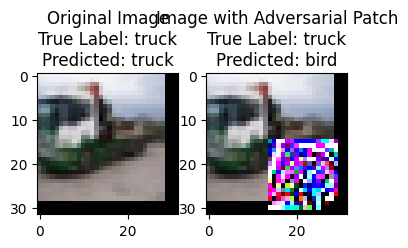

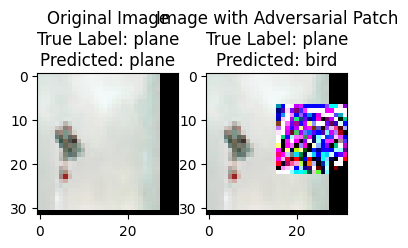

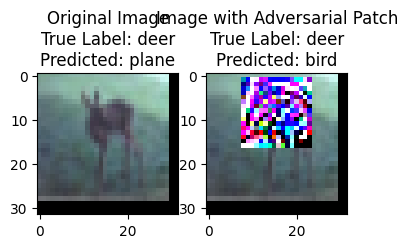

In [3]:
# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Targeted classes (plane, car, bird)
target_classes = [0, 1, 2]  # Corresponding to 'plane', 'car', and 'bird'

# Different patch sizes
patch_sizes = [(3, 3), (5, 5), (7, 7), (16, 16)]

# Train and evaluate patches for each target class
for target_class in target_classes:
    for patch_size in patch_sizes:
        print(f"\nTraining for patch size: {patch_size} with target class: {classes[target_class]}")
        patch = create_patch(patch_size)
        train_adversarial_patch(model, patch, target_class=target_class, num_epochs=20)

        # Save the patch
        torch.save(patch, f'adversarial_patch_{patch_size[0]}x{patch_size[1]}_target_{target_class}.pth')

        # Visualize the patch
        print(f"Visualizing patch of size {patch_size} for target class {classes[target_class]}")
        visualize_patch(patch)

        # Evaluate attack success rate
        evaluate_patch_success_rate(model, patch, testloader, target_class=target_class)

        # Visualize misclassified examples with the adversarial patch
        visualize_misclassified_patched_images(model, patch, testloader, classes, target_class, num_examples=5)
